In [39]:
pwd

'/sdf/data/lcls/ds/xpp/xppl1026722/results/LH_Tomography/TomoMono'

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tiffConverter import convert_to_numpy, convert_to_tiff

In [41]:
# scaling_factor = 1e6

# def scaleImage(image):
#     shift_value = image.min()
#     shifted_array = image - shift_value
#     scaled_array = shifted_array * scaling_factor

#     scaled_array = scaled_array.astype(np.int64)
#     return scaled_array, shift_value

# def unscaleImage(scaled_image, shift_value):
#     # Convert back to original range by dividing by the scaling factor
#     unscaled_array = scaled_image.astype(np.float64) / scaling_factor
    
#     # Add back the shift value
#     unscaled_array += shift_value

#     return unscaled_array


In [45]:
25430/3276

7.7625152625152625

float32


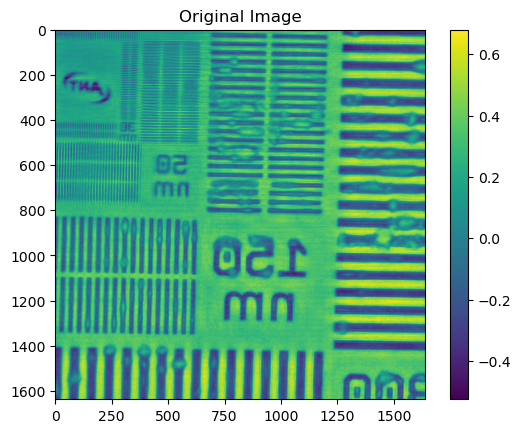

In [42]:
#Read in single image to perform correlation on

# # Low Contrast Projection (Low Contrast target)
# pixelSize = 23.2910 #nanometers (for projections)
# aligned_proj_location = "alignedProjections/aligned_baseCase_Filter_XCtip_20241004-100555.tif"
# kevinProjections, kevin_proj_scale_info = convert_to_numpy(aligned_proj_location)
# print(kevinProjections[0].shape)
# kevinProj1 = kevinProjections[0,50:550,200:700]
# print(kevinProj1.shape)

# High Contrast target
pixelSize = 25430/3276 #nanometers (for high contrast target)
aligned_proj_location = "/sdf/home/l/levih/xppl026722/results/shared/xppl1026722_Run0135/KMPIE_2024_12_19-12_05_10-0/final_image/final_image_KMPIE_2024_12_19-12_05_10-0_arg_M000@1.tiff"
kevinProjections, kevin_proj_scale_info = convert_to_numpy(aligned_proj_location)
kevinProj1 = kevinProjections[0]
# Crop central square half of the image
y, x = kevinProj1.shape
crop_size = min(y, x) // 2
y_center, x_center = y // 2, x // 2
y_start, y_end = y_center - crop_size // 2, y_center + crop_size // 2
x_start, x_end = x_center - crop_size // 2, x_center + crop_size // 2
kevinProj1 = kevinProj1[y_start:y_end, x_start:x_end]

plt.imshow(kevinProj1)
plt.title("Original Image")
plt.colorbar()
plt.show()

[[0.5  0.53 0.5  ... 0.54 0.54 0.49]
 [0.48 0.52 0.56 ... 0.49 0.51 0.5 ]
 [0.45 0.5  0.53 ... 0.45 0.47 0.55]
 ...
 [0.46 0.57 0.47 ... 0.55 0.52 0.39]
 [0.5  0.57 0.49 ... 0.5  0.51 0.49]
 [0.51 0.49 0.49 ... 0.48 0.44 0.53]]


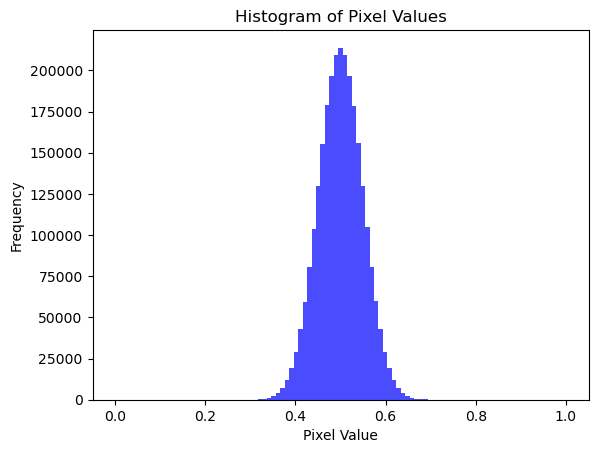

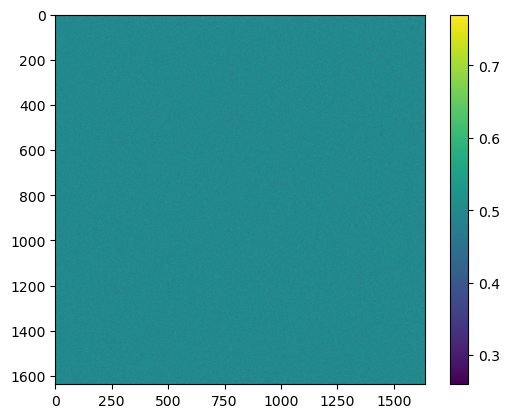

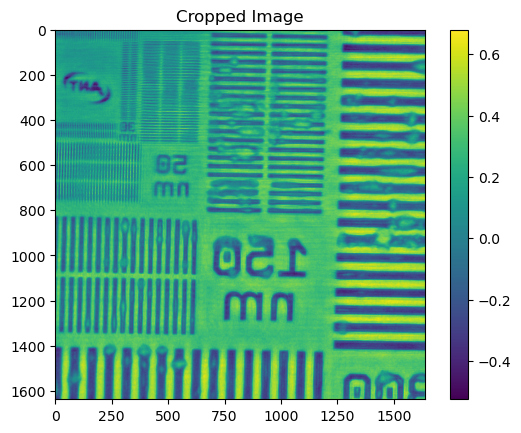

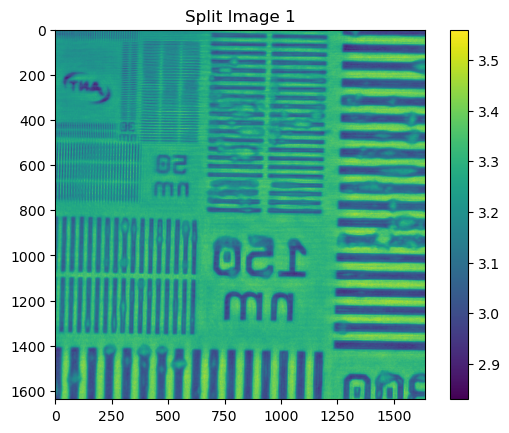

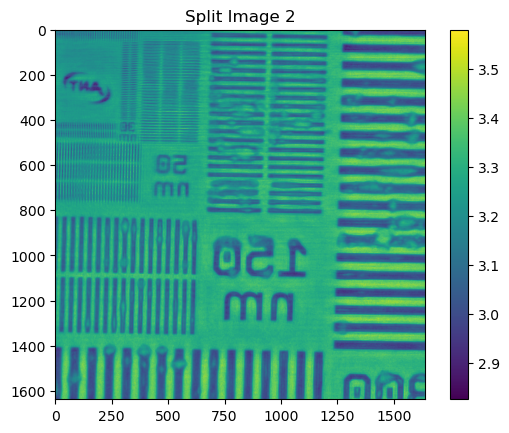

In [43]:
# #Scale image
# n, shift_value = scaleImage(kevinProj1) # Total photon counts for multiple pixels
# print(n.shape)

# # Split photon counts into n1 and n2
# n1 = np.random.binomial(n, 0.5)  # create n1 from a binomial distribution
# n2 = n - n1  # Remainder of pixel value assigned to n2

# n = unscaleImage(n, shift_value)
# n1 = unscaleImage(n1, shift_value)
# n2 = unscaleImage(n2, shift_value)



n = kevinProj1
probabilities = np.random.binomial(100*np.ones_like(n).astype(int), 0.5)/100
print(probabilities)

# Check that the probabilities follow a binomial distribution
flattened_image = probabilities.flatten()
plt.hist(flattened_image, bins=101, range=(0, 1), color='blue', alpha=0.7)
plt.title("Histogram of Pixel Values")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


plt.imshow(probabilities)
# n = n + np.pi
n1 = n * probabilities
n2 = n - n1

n1 = n1 + np.pi
n2 = n2 + np.pi
plt.colorbar()
plt.show()


plt.imshow(n)
plt.title("Cropped Image")
plt.colorbar()
plt.show()
plt.imshow(n1)
plt.colorbar()
plt.title("Split Image 1")
plt.show()
plt.imshow(n2)
plt.colorbar()
plt.title("Split Image 2")
plt.show()



In [44]:
convert_to_tiff(n2, "n2Image.tif")
convert_to_tiff(n1, "n1Image.tif")

In [46]:
print(n1.max())
print(n1.min())

3.5596433182531078
2.830246691899844


In [47]:
def radialSum(x):
    ''' modification of code by sajid an
    Based on the MATLAB code by Michael Wojcik
    '''
    shape = np.shape(x)     
    dim = np.size(shape)
    ''' Depending on the dimension of the image 2D/3D, create an array of integers 
    which increase with distance from the center of the array
    '''
    nr,nc = shape
    nrdc = np.floor(nr/2)
    ncdc = np.floor(nc/2)
    r = np.arange(nr)-nrdc 
    c = np.arange(nc)-ncdc  
    [R,C] = np.meshgrid(r,c)
    index =  np.round(np.sqrt(R**2+C**2)).astype(int)
    # indexf = np.floor(np.sqrt(R**2+C**2))
    # indexC = np.ceil(np.sqrt(R**2+C**2))

    maxindex = min(nr,nc)/2
    output = np.zeros(int(maxindex),dtype = complex)

    
    ''' In the next step output is generated. The output is an array of length
    maxindex. The elements in this array corresponds to the sum of all the elements
    in the original array correponding to the integer position of the output array 
    '''

    # indicesf, indicesC = [], []
    # for i in np.arange(int(maxindex)):
    #     # indices.append(np.where(index == i+1))
    #     indicesf.append(np.where(indexf == i))
    #     indicesC.append(np.where(indexC == i))

    # for i in np.arange(int(maxindex)):
    #     # output[i] = sum(x[indices[i]])/len(indices[i][0])
    #     output[i] = (sum(x[indicesf[i]])+sum(x[indicesC[i]]))/2

    indices = []
    for i in np.arange(int(maxindex)):
        indices.append(np.where(index == i))
    for i in np.arange(int(maxindex)):
        output[i] = sum(x[indices[i]])
    
    return output

In [48]:
from numpy import fft
def FRC( i1, i2, thresholding='half-bit', single_image=True):

    ''' Performing the fourier transform of input
    images to determine the FRC
    '''
    I1 = fft.fftshift(fft.fft2(i1))
    I2 = fft.fftshift(fft.fft2(i2))
    C  = radialSum(I1*np.conjugate(I2))
    C = np.real(C)
    C1 = radialSum(np.abs(I1)**2)
    C2 = radialSum(np.abs(I2)**2)
    C  = C.astype(np.float64)
    print(C1[0])
    C1 = np.real(C1).astype(np.float64)
    print(C1[0])
    C2 = np.real(C2).astype(np.float64)
    FSC    = abs(C)/np.sqrt(C1*C2)
    x_fsc  = np.arange(np.shape(C)[0])/(np.shape(i1)[0]/2)

    ''' perimeter of circle based calculation to
    determine n (number of values) in each ring
    '''
    r      = np.arange(np.shape(i1)[0]/2) # array (0:1:L/2-1)
    n      = 2*np.pi*r # perimeter of r's from above
    n[0]   = 1
    eps    = np.finfo(float).eps
    inv_sqrt_n = np.divide(np.ones(np.shape(n)),np.sqrt(n)) # 1/sqrt(n)
    x_T    = r/(np.shape(i1)[0]/2)



    if single_image:
      ''' Thresholding based on the fact that 
      SNR is split as the data is divided into
      two half datasets
      '''
      if (thresholding  == 'one-bit'):  T = (0.5+2.4142*inv_sqrt_n)/(1.5+1.4142*inv_sqrt_n) #information split
      elif(thresholding == 'half-bit'): T = (0.4142+2.287*inv_sqrt_n)/ (1.4142+1.287*inv_sqrt_n) # diagonal split 
      elif(thresholding == '0.5'):      T = 0.5*np.ones(np.shape(n))
      elif(thresholding =='em'):        T = (1/7)*np.ones(np.shape(n))
      else:
        t1 = (0.5+2.4142*inv_sqrt_n)/(1.5+1.4142*inv_sqrt_n)
        t2 = (0.2071+1.9102*inv_sqrt_n)/(1.2071+0.9102*inv_sqrt_n) # information split twice 
        t3 = 0.5*np.ones(np.shape(n))
        t4 = (1/7)*np.ones(np.shape(n))
        T = [t1, t2, t3, t4]
    else:  
      if (thresholding == 'one-bit'):  T = (1+3*inv_sqrt_n)/(2+2*inv_sqrt_n) # pixel split
      elif(thresholding == 'half-bit'):T = (0.4142+2.287*inv_sqrt_n)/ (1.4142+1.287*inv_sqrt_n) # diagonal split 
      elif(thresholding == '0.5'):     T = 0.5*np.ones(np.shape(n))
      elif(thresholding=='em'):        T = (1/7)*np.ones(np.shape(n))
      else:
          t1 = (1+3*inv_sqrt_n)/(2+2*inv_sqrt_n)
          t2 = (0.4142+2.287*inv_sqrt_n)/ (1.4142+1.287*inv_sqrt_n) 
          t3 = 0.5*np.ones(np.shape(n))
          t4 = (1/7)*np.ones(np.shape(n))
          T = [t1, t2, t3, t4]

    return (x_fsc, FSC, x_T, T)

0.06441211167911916
(74734982570816.47+0j)
74734982570816.47


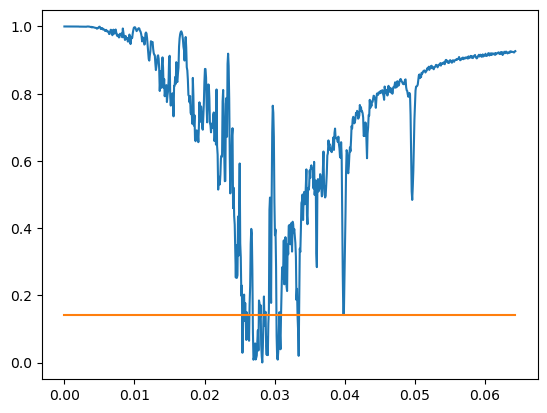

In [49]:
maxFrequency = 1/(2*pixelSize) #Based on the nyquist frequency
print(maxFrequency)
x_fsc, FSC, x_T, T = FRC(n1, n2, thresholding = "em")
p1 = plt.plot(x_fsc*maxFrequency, FSC)
p2 = plt.plot(x_T*maxFrequency, T)
# p1 = plt.plot(x_fsc, FSC)
# p2 = plt.plot(x_T, T)
plt.show(p1,p2)

In [50]:
# Find indices where T - FSC changes sign
diff = T - FSC
indices = np.where(np.diff(np.sign(diff)))[0]  # Points where sign changes


# Linear interpolation for precise intersection points
intersection_points = []
for i in indices:
    x1, x2 = x_fsc[i], x_fsc[i+1]
    y1, y2 = diff[i], diff[i+1]
    # Linear interpolation formula: x = x1 - y1 * (x2 - x1) / (y2 - y1)
    x_intersection = x1 - y1 * (x2 - x1) / (y2 - y1)
    intersection_points.append(x_intersection)

print("Pixel Size: ", pixelSize, "nm")
maxFrequency = 1/(2*pixelSize) #Based on the nyquist frequency
print("Max Frequency: ", maxFrequency, "nm^-1")
intersectionFrequency = intersection_points[0]*maxFrequency
print("Intersection Frequency: ", intersectionFrequency, "nm^-1")
resolution = 1/intersectionFrequency
print("Resolution: ", resolution, "nm")

Pixel Size:  7.7625152625152625 nm
Max Frequency:  0.06441211167911916 nm^-1
Intersection Frequency:  0.025358272851678788 nm^-1
Resolution:  39.434862376039035 nm
